In [398]:
%%capture
!pip install datasets
!pip install contractions

In [450]:
# Standard library imports
import logging
import re
import string

# Related third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud
import contractions

# Local application/library specific imports
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
import random
from datasets import load_dataset, concatenate_datasets

In [400]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [401]:
text_emotion_dataset = load_dataset("dair-ai/emotion", name="unsplit")

reddit_emotion_dataset = load_dataset("go_emotions", "raw")
reddit_emotion_dataset = reddit_emotion_dataset["train"]

twitter_emotion_dataset = load_dataset("tweet_eval", "emotion")

In [402]:
reddit_emotion_dataset = reddit_emotion_dataset.remove_columns(["link_id",
                                                                "author",
                                                                "id",
                                                                "parent_id",
                                                                "created_utc",
                                                                "subreddit",
                                                                "example_very_unclear",
                                                                "rater_id"
                                                                ])

In [403]:
reddit_emotion_features = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

def filter_zero_emotions(entry):
    return any(entry[emotion] > 0 for emotion in reddit_emotion_features)

def filter_single_emotion(entry):
    return sum(entry[emotion] for emotion in reddit_emotion_features) == 1

print("Original number of rows:", len(reddit_emotion_dataset))

reddit_emotion_dataset = reddit_emotion_dataset.filter(filter_zero_emotions)
reddit_emotion_dataset = reddit_emotion_dataset.filter(filter_single_emotion)

print("Filtered number of rows:", len(reddit_emotion_dataset))


Original number of rows: 211225
Filtered number of rows: 171820


In [404]:
reddit_emotion_dataset = reddit_emotion_dataset.to_pandas()

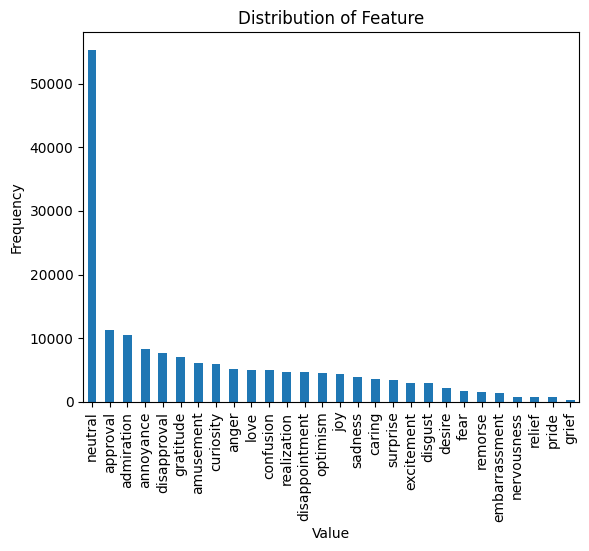

In [405]:
emotions_count = {}

for column in reddit_emotion_dataset.columns:
    if column != 'text':
        emotions_count[column] = (reddit_emotion_dataset[column] == 1).sum()

emotions_count = pd.Series(emotions_count)
emotions_count.sort_values(ascending=False, inplace=True)

emotions_count.plot(kind='bar')
plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [406]:
reddit_emotion_dataset["label"] = pd.from_dummies(reddit_emotion_dataset[reddit_emotion_features])
reddit_emotion_dataset = reddit_emotion_dataset[["text", "label"]]

### Twitter Dataset Preprocessing

In [407]:
twitter_emotion_dataset = concatenate_datasets([twitter_emotion_dataset["train"], twitter_emotion_dataset["validation"], twitter_emotion_dataset["test"]])
twitter_emotion_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 5052
})

In [408]:
twitter_emotion_df = twitter_emotion_dataset.to_pandas()
twitter_emotion_df['label'] = twitter_emotion_df['label'].astype('category')
twitter_emotion_df['label'] = twitter_emotion_df['label'].cat.rename_categories({0: "anger", 1: "joy", 2: "optimism", 3: "sadness"})
twitter_emotion_df


,text,label
0,“Worry is a down payment on a problem you may ...,optimism
1,My roommate: it's okay that we can't spell bec...,anger
2,No but that's so cute. Atsu was probably shy a...,joy
3,Rooneys fucking untouchable isn't he? Been fuc...,anger
4,it's pretty depressing when u hit pan on ur fa...,sadness
...,...,...
5047,I need a sparkling bodysuit . No occasion. Jus...,joy
5048,@user I've finished reading it; simply mind-bl...,sadness
5049,shaft abrasions from panties merely shifted to...,anger
5050,All this fake outrage. Y'all need to stop 🤣,anger


In [409]:
text_emotion_df = text_emotion_dataset["train"].to_pandas()
text_emotion_df['label'] = text_emotion_df['label'].astype('category')
text_emotion_df['label'] = text_emotion_df['label'].cat.rename_categories({0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"})

text_emotion_df

,text,label
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love
...,...,...
416804,that was what i felt when i was finally accept...,joy
416805,i take every day as it comes i m just focussin...,fear
416806,i just suddenly feel that everything was fake,sadness
416807,im feeling more eager than ever to claw back w...,joy


# Text Preprocessing

Firstly, combine all 3 datasets together.

In [410]:
emotion_df = pd.concat([twitter_emotion_df, text_emotion_df, reddit_emotion_dataset])
emotion_df

,text,label
0,“Worry is a down payment on a problem you may ...,optimism
1,My roommate: it's okay that we can't spell bec...,anger
2,No but that's so cute. Atsu was probably shy a...,joy
3,Rooneys fucking untouchable isn't he? Been fuc...,anger
4,it's pretty depressing when u hit pan on ur fa...,sadness
...,...,...
171815,"Well, I'm glad you're out of all that now. How...",joy
171816,Everyone likes [NAME].,love
171817,Well when you’ve imported about a gazillion of...,caring
171818,That looks amazing,admiration


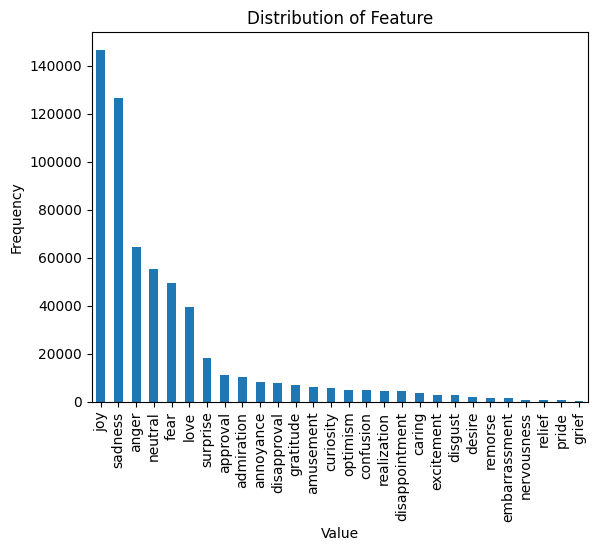

In [411]:
emotions_count = emotion_df['label'].value_counts()

emotions_count.plot(kind='bar')
plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Leave only the necessary classes with most of the data

In [412]:
emotion_df = emotion_df[emotion_df.label.isin(["text", "joy", "sadness", "anger", "neutral", "fear", "love", "surprise"])]
emotion_df = shuffle(emotion_df).reset_index(drop=True)
emotion_df

,text,label
0,"Damn, sometimes I love people here.",love
1,i can see why people adored this character but...,sadness
2,i feel just one thing from my mind that those ...,love
3,i read her post i thought about how differentl...,anger
4,But he wanted to!,neutral
...,...,...
500274,i feel cold and i feel so bored i am trapped i...,anger
500275,i feel indeed tvxq is highly respected in the ...,joy
500276,i feel too stupid to blay pridge,sadness
500277,i feel weird about immersing myself in a kid c...,surprise


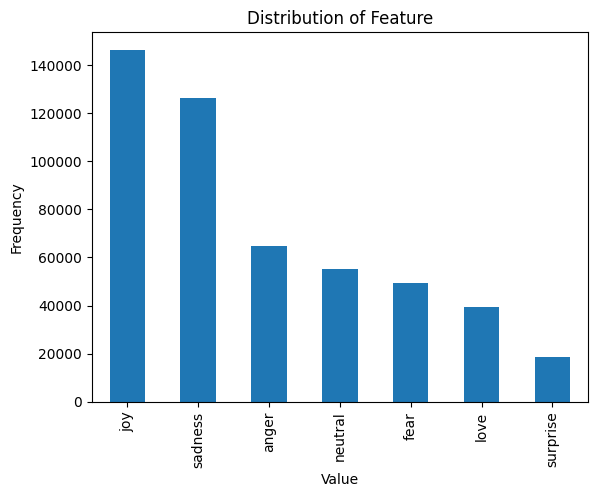

In [413]:
emotions_count = emotion_df['label'].value_counts()

emotions_count.plot(kind='bar')
plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Balance dataset

In [414]:
SAMPLES_PER_CLASS = 65000
balanced_emotion_df = emotion_df.groupby('label').apply(lambda x: x.sample(SAMPLES_PER_CLASS) if len(x) > SAMPLES_PER_CLASS else x)
balanced_emotion_df = balanced_emotion_df.sample(frac=1).reset_index(drop=True)
balanced_emotion_df = balanced_emotion_df.dropna()

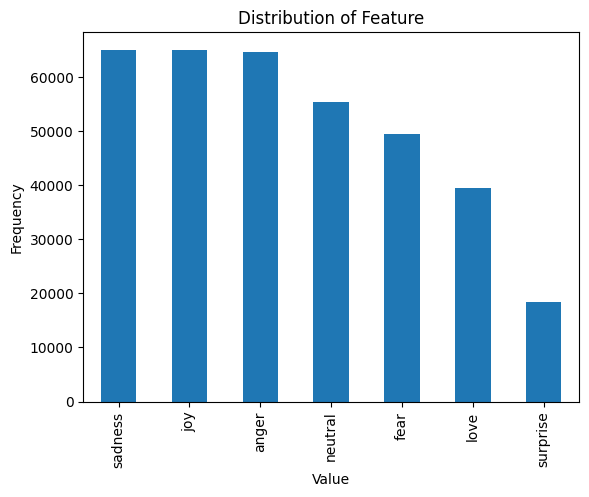

In [415]:
emotions_count = balanced_emotion_df['label'].value_counts()

emotions_count.plot(kind='bar')
plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [416]:
emotion_df['text']=emotion_df['text'].str.lower()

In [417]:
def expand_contractions(data):
  return contractions.fix(data)

emotion_df['text']= emotion_df['text'].apply(lambda x: expand_contractions(x))

In [418]:
retain_words = {'not', 'no', 'nor', "don't", "aren't", "couldn't", "didn't", "doesn't", "hadn't",
                "hasn't", "haven't", "isn't", "mustn't", "needn't", "shan't", "shouldn't", "wasn't",
                "weren't", "won't", "wouldn't", "but", "didn", "mightn't", "against", "wouldn", "weren", "aren",
                "ain", "won", "t", "s", "needn", "couldn", "d", "doesn", "don",  'should', "should've",'shouldn', "over"}

stopwords_set = set(stopwords.words('english')) - retain_words

In [419]:
def cleaning_email(data):
    return re.sub('@[^\s]+', '', data)

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

def cleaning_apostrophs(data):
    return re.sub('\'', '', data)

def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))','', data)

emotion_df['text']= emotion_df['text'].apply(lambda x: cleaning_email(x))
emotion_df['text']= emotion_df['text'].apply(lambda x: cleaning_numbers(x))
emotion_df['text'] = emotion_df['text'].apply(lambda x: cleaning_URLs(x))
emotion_df['text']= emotion_df['text'].apply(lambda x: cleaning_apostrophs(x))

emotion_df['text'] = emotion_df['text'].str.replace(r'\s+', ' ', regex=True)


In [420]:
def remove_stopwords(data):
  data = re.split(r"(\s+)", data)
  output_data = ""
  for word in data:
    if word in stopwords_set:
      output_data = output_data
    else:
      output_data += word

  return output_data.strip()

In [421]:
def cleaning_punct(data):
    punct_to_remove = string.punctuation.replace('!', '').replace('?', '')
    pattern = f"[{re.escape(punct_to_remove)}]"
    return re.sub(pattern, '', data)

emotion_df['text']= emotion_df['text'].apply(lambda x: cleaning_punct(x))

https://towardsdatascience.com/increasing-accuracy-of-sentiment-classification-using-negation-handling-9ed6dca91f53

In [422]:
non_negatable_pos = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD'}


def negate_sentence(sentence):
    words = nltk.word_tokenize(sentence)

    temp = 0
    i = 1  # start from 1 to safely check the previous word for negations

    # Process each word in the sentence
    while i < len(words):
        word = words[i-1]
        word_pos = nltk.pos_tag(word_tokenize(word))[0][1]

        if (word in ['not']) and (word_pos not in non_negatable_pos):
            antonyms = []
            synsets = wordnet.synsets(words[i])
            if synsets:
                w1 = synsets[0].name()
                # Find antonyms for each lemma
                for syn in synsets:
                    for l in syn.lemmas():
                        if l.antonyms():
                            antonyms.append(l.antonyms()[0].name())

                # If antonyms were found, choose the best one based on similarity
                if antonyms:
                    max_dissimilarity = 0
                    for ant in antonyms:
                        syns = wordnet.synsets(ant)
                        if syns:
                            w2 = syns[0].name()
                            word1 = wordnet.synset(w1)
                            word2 = wordnet.synset(w2)
                            similarity = word1.wup_similarity(word2)
                            if similarity:
                                temp = 1 - similarity
                                if temp > max_dissimilarity:
                                    max_dissimilarity = temp
                                    antonym_max = ant
                                    words[i] = antonym_max  # Replace with the best antonym
                                    words[i-1] = ''  # Remove the negation word

        i += 1

    words = [word for word in words if word]

    sentence = ' '.join(words)
    sentence = re.sub(r' \?', '?', sentence)
    sentence = re.sub(r' !', '!', sentence)
    sentence = re.sub(r' \' ', '\'', sentence)
    return sentence

In [423]:
test_negation = emotion_df["text"][random.randint(0, 1000)]
print(test_negation)
print(negate_sentence(test_negation))

i got this mirror because i was starting to feel a little vulnerable when cars were passing me
i got this mirror because i was starting to feel a little vulnerable when cars were passing me


Separate features and target

In [424]:
X = balanced_emotion_df['text']
y = balanced_emotion_df.drop('text', axis=1)

balanced_emotion_df['text'] = X
balanced_emotion_df['label'] = y

In [425]:
y = pd.get_dummies(y, columns=['label'])
y = y.astype(int)

# Tokenization

In [426]:
max_len = 200
tok = Tokenizer(num_words=20000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

In [427]:
# Maximum Length in X_train_sequences
maxlen = max(len(tokens) for tokens in sequences)
print("Maximum sequence length (maxlen):", maxlen)

sequences_matrix.shape

Maximum sequence length (maxlen): 178


(357380, 200)

In [428]:
tok.index_word[20000]

'recollections'

In [429]:
X_train, X_test, y_train, y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)


# Model Development

In [430]:
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=3,
                                        restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1)

In [431]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(
      input_dim=20000,
      output_dim=100,
      mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.3)),

  tf.keras.layers.Dense(64),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dropout(0.4),

  tf.keras.layers.Dense(7, activation='softmax')
])

In [432]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [433]:
history = model.fit(X_train[:50000], y_train[:50000], batch_size=80, epochs=15, validation_split=0.25, verbose=1, callbacks=[early_stopping_callback, reduce_lr])

Epoch 1/15
469/469 [==============================] - 351s 717ms/step - loss: 0.9804 - accuracy: 0.6609 - precision_5: 0.8297 - recall_5: 0.5240 - val_loss: 0.5191 - val_accuracy: 0.8493 - val_precision_5: 0.8995 - val_recall_5: 0.7479 - lr: 0.0010
Epoch 2/15
469/469 [==============================] - 323s 689ms/step - loss: 0.4028 - accuracy: 0.8752 - precision_5: 0.9017 - recall_5: 0.8466 - val_loss: 0.4583 - val_accuracy: 0.8517 - val_precision_5: 0.8710 - val_recall_5: 0.8348 - lr: 0.0010
Epoch 3/15
469/469 [==============================] - 338s 719ms/step - loss: 0.2741 - accuracy: 0.9134 - precision_5: 0.9290 - recall_5: 0.8956 - val_loss: 0.4174 - val_accuracy: 0.8659 - val_precision_5: 0.8806 - val_recall_5: 0.8498 - lr: 0.0010
Epoch 4/15
469/469 [==============================] - 342s 730ms/step - loss: 0.2145 - accuracy: 0.9309 - precision_5: 0.9430 - recall_5: 0.9194 - val_loss: 0.4448 - val_accuracy: 0.8645 - val_precision_5: 0.8773 - val_recall_5: 0.8518 - lr: 0.0010
Epoc

In [434]:
accr1 = model.evaluate(X_test[:10000], y_test[:10000]) #we are starting to test the model here


313/313 [==============================] - 25s 79ms/step - loss: 0.4343 - accuracy: 0.8586 - precision_5: 0.8749 - recall_5: 0.8445


In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [436]:
model.save("my_model.keras")

In [437]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_4 (Bidirecti  (None, 128)               84480     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_4 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 64)                0         
                                                                 
 dropout_4 (Dropout)         (None, 64)               

In [438]:
text = "i do dislike talking about that"
sequences = tok.texts_to_sequences([text])
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
sequences

[[1, 37, 2221, 369, 28, 8]]

In [439]:
prediction = model.predict(sequences_matrix)
predicted_index = np.argmax(prediction)

predicted_label = y.columns[predicted_index]
print(predicted_label)

1/1 [==============================] - 4s 4s/step
label_neutral


In [440]:
predictions = model.predict(X_test[:5000])
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test[:5000], axis=1)

cm = confusion_matrix(true_classes, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

157/157 [==============================] - 11s 72ms/step
[[0.8590604  0.02796421 0.00671141 0.00559284 0.06599553 0.03355705
  0.00111857]
 [0.04038997 0.84818942 0.00278552 0.00139276 0.02367688 0.03203343
  0.05153203]
 [0.01997897 0.01156677 0.80231335 0.09568875 0.02313354 0.01997897
  0.02733964]
 [0.00369004 0.00553506 0.03136531 0.90590406 0.04428044 0.00553506
  0.00369004]
 [0.04450262 0.0104712  0.01439791 0.01832461 0.86649215 0.03272251
  0.01308901]
 [0.02502844 0.02161547 0.01592719 0.00682594 0.02275313 0.90102389
  0.00682594]
 [0.01587302 0.10714286 0.02380952 0.00396825 0.11507937 0.00396825
  0.73015873]]


<Figure size 1500x1500 with 0 Axes>

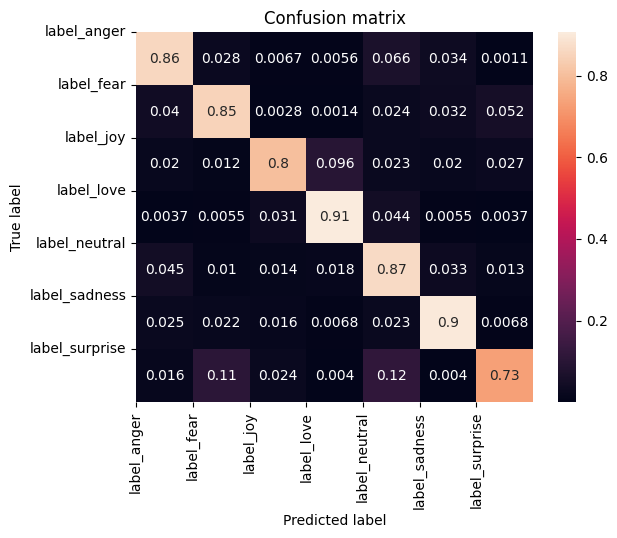

<Figure size 1500x1500 with 0 Axes>

In [441]:
classes = y.columns

sns.heatmap(cm, annot=True)
plt.title('Confusion matrix')

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes, rotation=0)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.figure(figsize=(15, 15))